<a href="https://colab.research.google.com/github/sonsus/SamsungLab_Lecture/blob/master/Cifar10_CNN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification 예제 (pytorch)
## CNN 으로 CIFAR-10 분류하기 

- Google Colab: 구글 드라이브 + jupyter lab + 클라우드 인스턴스 제공 (무료의 경우 GPU 가속 인스턴스는 12시간까지만 연속 사용 가능)

- CIFAR10 데이터셋   
[CIFAR10](http://www.cs.toronto.edu/~kriz/cifar.html)   
[CIFAR10 classification records](https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130)

- Pytorch Tensor Basic operations 
[링크](https://jhui.github.io/2018/02/09/PyTorch-Basic-operations/)  
혹은 그냥 웬만한 튜토리얼들 좋은 자료들이 많다

- CNN 구조 및 하이퍼파라미터 참조
[솔라리스의 인공지능: TF 구현](http://solarisailab.com/archives/2325)

## step 0: 이 문서를 google drive에서 사본을 만든다
> 그리고 거기에서 진행해주세요!

In [0]:
#런타임 유형 변경 --> GPU
!nvidia-smi

Mon May 13 04:08:16 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
!pip3 install https://download.pytorch.org/whl/cu100/torch-1.1.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install scipy

In [0]:
import torch
import torchvision

print(torch.cuda.is_available())
device = torch.device('cuda')

True


Files already downloaded and verified
(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F0CFC573668>, 7)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
horse


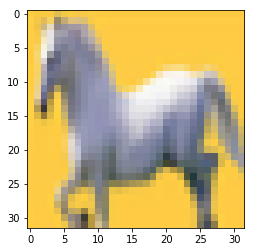

In [0]:
##dataset_walkthru

from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt 

# cifar10
# http://www.cs.toronto.edu/~kriz/cifar.html
cifar10_glance = CIFAR10('./', train=False, download=True)
cifar10_glance._load_meta()
idx2clsname = cifar10_glance.classes # list of classes' in the dataset

anitem = cifar10_glance[808] # (PIL.Image.Image, cls_idx)
print(anitem)

anitem_pic = anitem[0]
plt.imshow(anitem_pic)

print(idx2clsname)
print(idx2clsname[anitem[1]])

#type(anitem[1])

In [0]:
#dataloader.py

import torch.nn as nn
from torch.utils.data import DataLoader
from pdb import set_trace
from torchvision import transforms


#tranform: PIL image --> tensors
ds_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), #means for each channel
                         (0.229, 0.224, 0.225))]) #stds



cf10_train = CIFAR10('./', train=True, transform=ds_transform,  download=True)

cf10_train._load_meta()
idx2label = cf10_train.classes
print(idx2label == idx2clsname) #unseen things are not knowledgeable
print(len(cf10_train))    

def collate_fn(items):
  image_tensors, idxs  = item
  return torch.stack(image_tensor), torch.Tensor(idxs).long()


def get_loader(dataset, transform=None, batch_size=100, shuffle=True, drop_last=True):
  data_loader = DataLoader(dataset=dataset, 
                           batch_size=batch_size, shuffle=True, drop_last=True)
  return data_loader

Files already downloaded and verified
True
50000


## 모델
### CNN 구조와 설명은 아래의 링크를 따라가보자
[CS231n: CNN 구조(번역본)](http://aikorea.org/cs231n/convolutional-networks/
)

> 구조 세부에 대해서는 개략적으로 칠판에 설명해드릴 예정

In [0]:
#model.py

from torch.nn import functional as F

#this CNN would work for only 32x32 images with 3 channels 
class SimpleCNN(nn.Module): 
  def __init__(self, target_size):
    super(SimpleCNN, self).__init__()
    self.conv0 = nn.Conv2d(3,64,5, padding=1) #in-channel, #out-channel, kernel_size
    self.conv1 = nn.Conv2d(64,64,5, padding=1)
    self.conv2 = nn.Conv2d(64,128,3, padding=1)
    self.conv3 = nn.Conv2d(128,128,3, padding=1)
    self.conv4 = nn.Conv2d(128,128,3, padding=1)
    self.fc0 = nn.Linear(7*7*128, 384)
    self.fc1 = nn.Linear(384,10)
    #self.bn0 = nn.BatchNorm1d(17**2, momentum=0.01)
    #self.bn1 = nn.BatchNorm1d(target_size, momentum=0.01)
    
  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv0(x), kernel_size=3, stride=2, padding=1))
    x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=2, padding=1))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    #batch, chan, xaxis, yaxis = x.shape 
    x = F.dropout(F.relu(self.fc0(x.view(-1, 7*7*128))), p=0.3)
    x = self.fc1(x)
    prob = F.log_softmax(x, dim=0) #numerical stability issue--> use log()
    
    return prob

## 학습
### training loss < validation loss --> overfitting
- 그러므로 그 전까지만 트레이닝 한다        

### Cross Validation
- 내가 고른 test_set 은 generalizability를 보장하는가?
- test set을 바꿔서 다 해보자
- test set이 정해져있다면 validation을 k-fold CV로 모델 선택에 활용이 가능하다.

### more about loss
https://ratsgo.github.io/deep%20learning/2017/09/24/loss/

![대체 텍스트](https://www.researchgate.net/profile/B_Aksasse/publication/326866871/figure/fig2/AS:669601385947145@1536656819574/K-fold-cross-validation-In-addition-we-outline-an-overview-of-the-different-metrics-used.jpgg)

In [0]:
cf10_test = CIFAR10('./', train=False, transform=ds_transform,  download=True)
test_loader = get_loader(cf10_test, shuffle=False)
len(test_loader)

Files already downloaded and verified


100

In [0]:
#train.py
train_loader = get_loader(cf10_train, batch_size=100) #transform=ds_transform)

#1 epoch = 500 batches 

CNNmodel= SimpleCNN(len(idx2label)).to(device)

#params to be optimized 
params = CNNmodel.parameters()
#optimizer
optimizer = torch.optim.Adam(params, lr=5e-4)

#lr scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='max', 
                                                       factor=0.5, 
                                                       patience=2, 
                                                       verbose=True)
#criterion
criterion = nn.NLLLoss()

val_loss = 0
train_loss = 0
epoch = 0 

prec = 0
tprec_sum = 0
vprec_sum = 0

train_prec_avg = 0
val_prec_avg = 0

overfitcount = 0 

#CNNmodel.load_state_dict(torch.load('solaris_SimpleCNN-36.pth'))
#epoch=37

while epoch < 50:  
  tprec_sum =0 
  vprec_sum =0
  train_loss =0
  val_loss =0
  for batch, (b_img_t, b_label) in enumerate(train_loader):
    b_img_t = b_img_t.to(device)
    b_label = b_label.to(device)
    #if batch<400:
    optimizer.zero_grad()# or CNNmodel.zero_grad()
    CNNmodel.train()
    train_loss = 0
    b_pred = CNNmodel(b_img_t)
    loss = criterion(b_pred ,b_label)
    prec = (b_pred.argmax(dim=1)==b_label).float().sum()/len(b_label)

    if batch %100==1:
      print("TRAIN: ep = {}, batch = {}, loss = {}, precision = {}".format(epoch, batch, loss, prec))

    loss.backward() #calculate gradients of params
    optimizer.step() #update params based on gradients
    train_loss += loss.item() #caution!
    tprec_sum+=prec 
    
    #else: # batch: 400~499
  for vbatch,(b_img_t, b_label) in enumerate(test_loader):
    if vbatch>=50: break
    b_img_t = b_img_t.to(device)
    b_label = b_label.to(device)

    CNNmodel.eval() #freeze params
    val_loss = 0
    b_pred = CNNmodel(b_img_t)
    prec = (b_pred.argmax(dim=1)==b_label).float().sum()/len(b_label)
    val_loss += criterion(b_pred ,b_label).item()
    if vbatch %10 ==1:
      print("VAL: ep = {}, batch = {}, loss = {}, prec = {}".format(epoch, batch, val_loss, prec))
    vprec_sum += prec
    
  
  train_prec_avg = tprec_sum/500
  val_prec_avg = vprec_sum/50
  scheduler.step(val_prec_avg)
  
    
  train_loss /= 400
  val_loss/= 400
  
  print('AVG: epoch: {ep},\ntrainloss: {tl}, trainprecavg: {trp},\nvalidloss: {vl}, validprecavg: {valp}'.format(ep=epoch, tl=train_loss, vl=val_loss, trp= train_prec_avg, valp =val_prec_avg))



  #if train_prec_avg < val_prec_avg:
  #  overfitcount+=1; print('overfitwarn:', overfitcount) 
  torch.save(CNNmodel.state_dict(), './solaris_SimpleCNN-{}.pth'.format(epoch))
  print('saved model-epoch: ', epoch)
  #if overfitcount>10: 
  #  break; print('end training, ep: ', epoch)
  epoch+=1
  






TRAIN: ep = 0, batch = 1, loss = 4.5993547439575195, precision = 0.17999999225139618
TRAIN: ep = 0, batch = 101, loss = 4.0462327003479, precision = 0.3700000047683716
TRAIN: ep = 0, batch = 201, loss = 3.9025940895080566, precision = 0.3700000047683716
TRAIN: ep = 0, batch = 301, loss = 3.65437650680542, precision = 0.5199999809265137
TRAIN: ep = 0, batch = 401, loss = 3.4310302734375, precision = 0.6299999952316284
VAL: ep = 0, batch = 499, loss = 3.4658446311950684, prec = 0.6399999856948853
VAL: ep = 0, batch = 499, loss = 3.3683907985687256, prec = 0.7199999690055847
VAL: ep = 0, batch = 499, loss = 3.4091250896453857, prec = 0.6399999856948853
VAL: ep = 0, batch = 499, loss = 3.526055335998535, prec = 0.5999999642372131
VAL: ep = 0, batch = 499, loss = 3.4587979316711426, prec = 0.550000011920929
AVG: epoch: 0,
trainloss: 0.00912075400352478, trainprecavg: 0.47808021306991577,
validloss: 0.008623740673065185, validprecavg: 0.6000000834465027
saved model-epoch:  0
TRAIN: ep = 1, b

In [0]:
#cf10_test = CIFAR10('./', train=False, transform=ds_transform,  download=True)
#test_loader = get_loader(cf10_test, shuffle=True)

testmodel = SimpleCNN(len(idx2label)).to(device)
for i in range(47, 48):
  load_ep=i

  testmodel.load_state_dict(torch.load('./solaris_SimpleCNN-'+str(load_ep)+'.pth'))
  testmodel.eval()
  listprec= []
  for i in range(10):
    sum_prec = 0
    for vbatch, (b_img_t, b_label) in enumerate(test_loader):
      if vbatch<50: continue
      b_img_t = b_img_t.to(device)
      b_label = b_label.to(device)

      pred = testmodel(b_img_t).argmax(dim=1)
      b_prec = (pred==b_label).float().sum()/len(b_label) # len(b_label == batchlen)
      sum_prec+=b_prec

    testset_prec = 2*sum_prec/len(test_loader)
    listprec.append(testset_prec)
    print(testset_prec)
    print("answers:", b_label, "\npredictions:", pred)
  print(load_ep, (torch.stack(listprec).flatten().sum()/10).item())
  

tensor(0.8100, device='cuda:0')
answers: tensor([1, 8, 9, 8, 7, 8, 4, 1, 3, 6, 9, 8, 5, 4, 2, 4, 1, 5, 6, 6, 6, 9, 2, 8,
        7, 1, 9, 1, 9, 1, 2, 8, 9, 2, 1, 3, 0, 6, 8, 9, 5, 1, 5, 3, 8, 7, 2, 6,
        0, 6, 6, 2, 4, 4, 9, 4, 0, 0, 6, 5, 0, 7, 2, 0, 6, 0, 4, 0, 2, 5, 9, 6,
        6, 6, 4, 0, 2, 1, 4, 4, 6, 8, 0, 8, 6, 1, 6, 4, 1, 7, 2, 1, 9, 5, 2, 3,
        0, 0, 2, 3], device='cuda:0') 
predictions: tensor([1, 8, 9, 8, 2, 8, 4, 1, 7, 6, 9, 8, 5, 6, 2, 4, 1, 2, 6, 6, 2, 9, 7, 8,
        7, 1, 9, 1, 3, 1, 7, 8, 9, 2, 1, 3, 0, 6, 8, 9, 5, 1, 5, 3, 8, 7, 2, 6,
        0, 6, 6, 9, 4, 4, 9, 4, 0, 0, 4, 3, 8, 7, 2, 0, 6, 0, 4, 8, 2, 5, 8, 6,
        4, 6, 4, 0, 2, 1, 4, 4, 6, 5, 0, 8, 4, 1, 3, 4, 1, 7, 0, 1, 9, 5, 2, 3,
        0, 0, 5, 4], device='cuda:0')
tensor(0.8094, device='cuda:0')
answers: tensor([3, 8, 4, 0, 9, 8, 3, 1, 8, 8, 3, 2, 0, 6, 9, 7, 2, 9, 6, 5, 3, 7, 2, 0,
        0, 5, 8, 4, 2, 8, 6, 4, 1, 6, 3, 1, 9, 8, 8, 6, 2, 9, 3, 9, 2, 4, 7, 9,
        1, 8, 7, 6, 3, 6, 2,

In [0]:
!nvidia-smi

In [0]:
torch.cuda.empty_cache()